In [1]:
!pip install -Uqq duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.4 MB/s eta 0:00:00


In [5]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images_ddg(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [6]:
urls = search_images_ddg('bird photos', max_images=1)
len(urls),urls[0]

(1,
 'https://www.almanac.com/sites/default/files/image_nodes/bluebird-3456115_1920.jpg')

In [13]:
from fastdownload import download_url
dest = Path( 'bird.jpg')

if not dest.exists(): download_url(urls[0], dest, show_progress=False)

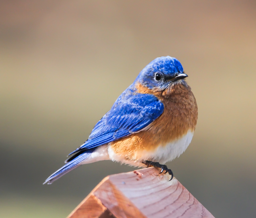

In [15]:
from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [16]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

In [17]:
failed = verify_images(get_image_files(path))
failed .map(Path. unlink);

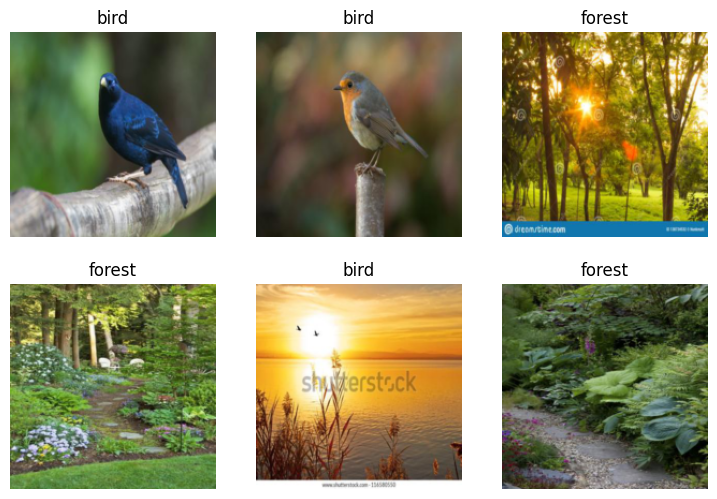

In [18]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [19]:

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 16.0MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.518923,0.110890,0.034314,02:03


epoch,train_loss,valid_loss,error_rate,time
0,0.087489,0.042304,0.024510,02:59
1,0.052663,0.045777,0.024510,02:51
2,0.038020,0.051425,0.019608,02:49


In [20]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
